# Finetune a pretrained imageNet CNN for cifar10 classification

**Goal:**  The goal is to use a pretrained CNN 

**Usage:** The idea of the notebook is that you try to understand the provided code by running it, checking the output and playing with it by slightly changing the code and rerunning it.  

**Dataset:** In this notebook you work with the Cifar10 dataset. You have 60'000 32x32 pixel color images of 10 classes ("airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck").  


Original python version CHECK AND ADAPT
| [open in colab](https://colab.research.google.com/github/tensorchiefs/dl_book/blob/master/chapter_02/nb_ch02_03.ipynb)


# Installing TensorFlow and Keras

The deep learning packages, TensorFlow and Keras are not installed by default, but can be installed as follows:

In [1]:
#Installing TF and Keras (no needed for TFP)
if (FALSE){
    #Takes about 2 Minutes
    ptm <- proc.time()
        install.packages("tensorflow")
        install.packages("keras")
        install.packages("RCurl")
        install.packages("kableExtra")
        install.packages("reshape2")
    proc.time() - ptm
    #devtools::install_github("rstudio/keras") works ok but no tfp
}

# Imports

In the next cell, we load all the required libraries and functions. 

In [2]:
library(keras)
library(tensorflow)
tf$version$VERSION  #2.6.5
library(tidyverse)
require(graphics)

Loaded Tensorflow version 2.6.5



[1] "2.6.5"

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


# Data
Let's get the cifar10 data. Normalize the image data and reformat the labels to one-hot-encoded. m

In [73]:
num_images_train = 1000
cifar10 <- dataset_cifar10()
c(x_train, y_train) %<-% cifar10$train
#Short for 
#  x_train = cifar10$train$x
#  y_train = cifar10$train$y
c(x_test, y_test) %<-% cifar10$test

to_one_hot <- function(labels, dimension = 10) {
  results <- matrix(0, nrow = length(labels), ncol = dimension)
  for (i in 1:length(labels))
    results[i, labels[[i]] + 1] <- 1
  results
}
X_train <- x_train[1:num_images_train,,,]/255
X_val <- x_train[10001:11000,,,]/255
X_test <- x_test/255

Y_train <- to_one_hot(y_train[1:num_images_train])
Y_val <- to_one_hot(y_train[10001:11000])
Y_test <- to_one_hot(y_test)

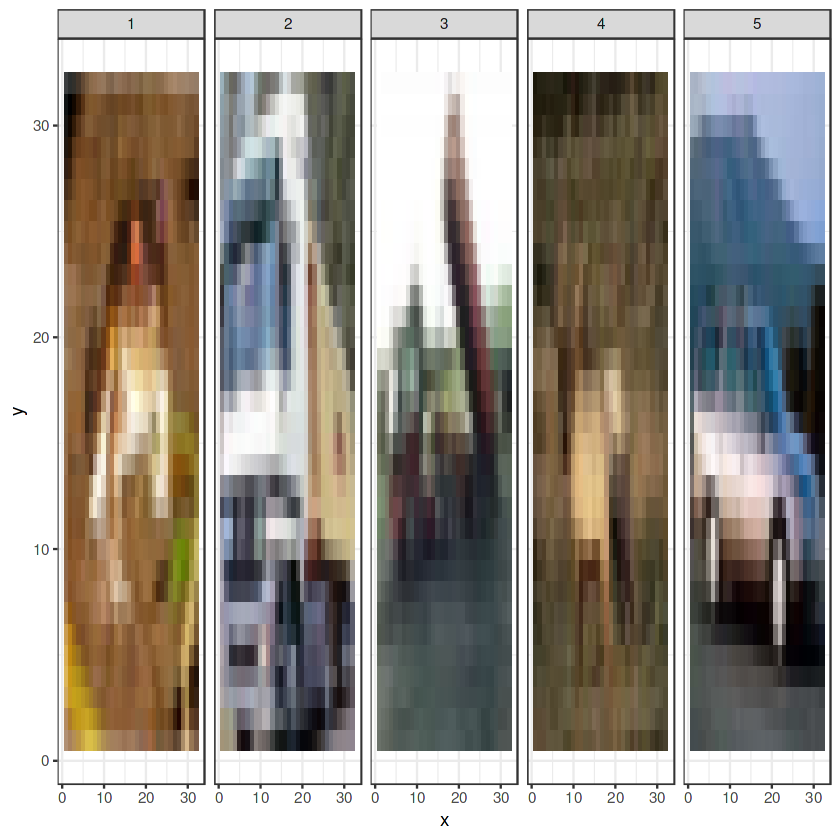

In [15]:
#have a look on the images:
dd <- expand.grid(1:32,1:32)
colnames(dd) <- c("x","y")
dd <- data.frame(x=rep(dd$x,5),y=rep(dd$y,5))
dd$r <- NA
dd$g <- NA
dd$b <- NA
dd$pic <- rep(1:5,each=32*32)
idx <- 32:1
idx2 <- c("r","g","b")

for (k in 1:5){
  for (j in 1:3){
    for (i in 1:32){
      dd[dd$y==idx[i] & dd$pic==k,idx2[j]] <- x_train[k,i,,j]
    }
  }
}
dd$r <- dd$r/255
dd$g <- dd$g/255
dd$b <- dd$b/255
ggplot(data=dd, aes(x=x, y=y, fill=rgb(r,g,b))) +
  geom_tile() +
  scale_fill_identity() +
  theme_bw()+
  facet_wrap(~pic,ncol=5)

# Working with a pretrained VGG model

Let's instantiate the VGG16 model that was trained on the huge imageNet data (1000000 instances) with 1000 classes:

In [5]:
## edit from original keras function:
application_vgg16 = function (include_top = TRUE,
                              weights = "imagenet",
                              input_tensor = NULL,
                              input_shape = NULL,
                              pooling = NULL,
                              classes = 1000){
  # MP: comment out next line
  #verify_application_prerequistes()
  # MP: prefix "tf$" to next line.
  tf$keras$applications$VGG16(include_top = include_top, weights = weights, 
    input_tensor = input_tensor, 
    # MP: comment out next line, include succeeding line
    #input_shape = normalize_shape(input_shape)
    input_shape = input_shape, 
    pooling = pooling, classes = as.integer(classes))
}

In [6]:
base_model <- application_vgg16(weights = "imagenet",
                           include_top = FALSE,
                           input_shape = c(32L, 32L, 3L))
summary(base_model)

Model: "vgg16"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
input_1 (InputLayer)                [(None, 32, 32, 3)]             0           
________________________________________________________________________________
block1_conv1 (Conv2D)               (None, 32, 32, 64)              1792        
________________________________________________________________________________
block1_conv2 (Conv2D)               (None, 32, 32, 64)              36928       
________________________________________________________________________________
block1_pool (MaxPooling2D)          (None, 16, 16, 64)              0           
________________________________________________________________________________
block2_conv1 (Conv2D)               (None, 16, 16, 128)             73856       
________________________________________________________________________________
block2_conv2 

In [7]:
# i.e. freeze all convolutional VGG16 layers
freeze_weights(base_model)

### Random Forest Model 

In [8]:
features = base_model$output %>% layer_flatten()
model_feature <- keras_model(
    inputs = base_model$input, 
    outputs = features)

In [25]:
X_train_features = model_feature(X_train)
X_val_features = model_feature(X_val)
X_test_features = model_feature(X_test)

In [32]:
str(as.matrix(Y_train))

 num [1:1000, 1:10] 0 0 0 0 0 0 0 0 0 0 ...


In [47]:
library(randomForest)
df_train = data.frame(
     y = as.factor(as.character(y_train[1:1000])),
     as.matrix(X_train_features)
)
df_test = data.frame(
     #y = as.factor(as.character(y_test)),
     as.matrix(X_test_features)
)

In [46]:
rf = randomForest(y ~ ., df_train)

In [48]:
pred_rf = predict(rf, df_test)

In [54]:
acc_rf = mean(pred_rf == as.factor(as.character(y_test)))

In [61]:
table(y_test)
table(pred_rf)
table(y_test , pred_rf)

y_test
   0    1    2    3    4    5    6    7    8    9 
1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 

pred_rf
   0    1    2    3    4    5    6    7    8    9 
1104 1298  607  807 1000  868 1192  968 1059 1097 

      pred_rf
y_test   0   1   2   3   4   5   6   7   8   9
     0 537  53  65  19  43  19  14  33 172  45
     1  56 545  14  32  14  30  43  30  47 189
     2 126  48 237  67 141 109 141  68  42  21
     3  54 101  62 276  49 154 116  75  27  86
     4  27  35  50  50 423  32 159 107  66  51
     5  21  60  47 176  70 359  79 114  22  52
     6  19  87  54  82  87  56 564  17  16  18
     7  54  47  39  42 100  73  30 456  28 131
     8 120 117  20  21  35   7  12  12 570  86
     9  90 205  19  42  38  29  34  56  69 418

### Finetuning Model

In [62]:
# prepare new head for our 10 cifar10 classes 
predictions <- base_model$output %>% 
    layer_flatten() %>% 
    layer_dense(units = 100, activation = "relu") %>% 
    layer_dropout(rate = 0.2) %>%
    layer_dense(units = 10, activation = "softmax")

In [63]:
summary(predictions)

KerasTensor(type_spec=TensorSpec(shape=(None, 10), dtype=tf.float32, name=None), name='dense_2/Softmax:0', description="created by layer 'dense_2'")


In [65]:
# this is the model we will train
model <- keras_model(inputs = base_model$input, outputs = predictions)
# summary(model)

In [66]:
# compile model
model %>% compile(
  optimizer = "adam",
  loss = "categorical_crossentropy",
  metrics = c("accuracy")
)

Finetune the VGG model (with frozen convolutional part) to the cifar10 data:

In [68]:
history <- model %>% fit(
  X_train, Y_train, 
  epochs = 20,
  batch_size=128,
  verbose=0,
  validation_data = list(X_val, Y_val))

`geom_smooth()` using formula 'y ~ x'



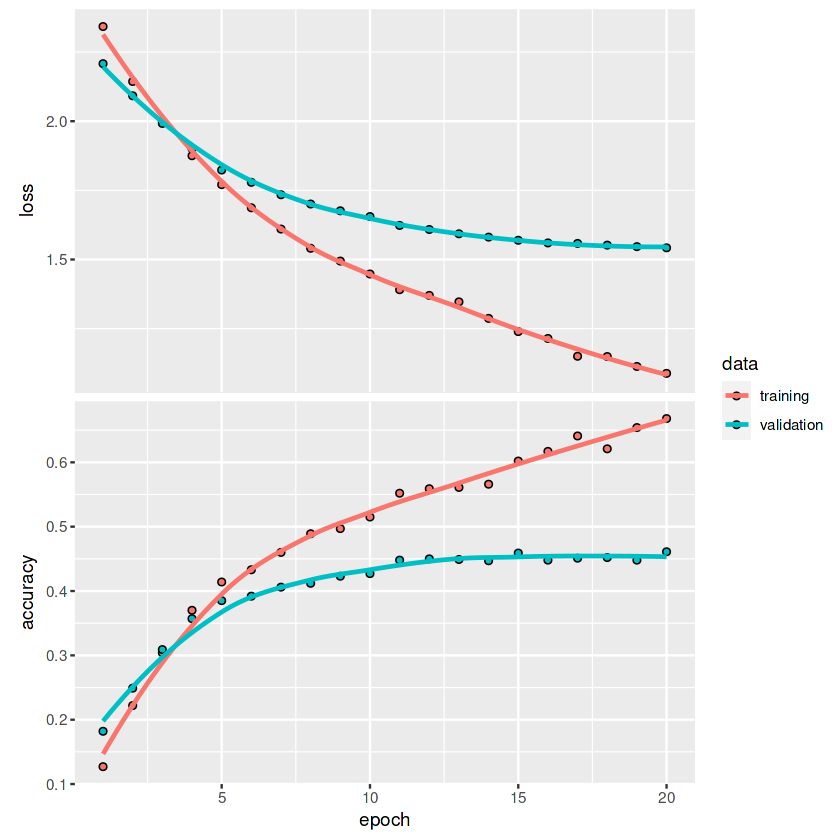

In [69]:
plot(history)

In [74]:
results_fine <- model %>% evaluate(X_test, Y_test, verbose=0)
results_fine

loss accuracy 
1.533804 0.465700

In [75]:
acc_rf

[1] 0.4385

Prepare the labels as one-hot-encoded.


# Exercise
<img src="https://raw.githubusercontent.com/tensorchiefs/dl_book/master/imgs/paper-pen.png" width="60" align="left" />  

Now train a CNN from scratch using only the 1000 examples in the training set. Use the same  architecture as https://github.com/tensorchiefs/dl_rcourse_2022/blob/main/notebooks/04_nb_ch02_03.ipynb. Compare the prediction performance on the testset, with the results above and the results obtained using the full training set. 

Try yourself first before you scroll down to the solution.


In [81]:
## Your Code Here

.

.

.

.

.

.

.

.

.

.

# Solution (try first yourself) CNN Training from scratch

We use the same architecture as https://github.com/tensorchiefs/dl_rcourse_2022/blob/main/notebooks/04_nb_ch02_03.ipynb

In [76]:
batch_size = 128
nb_classes = 10
img_rows = 32
img_cols = 32
kernel_size = c(3, 3)
input_shape = c(img_rows, img_cols, 3)
pool_size = c(2, 2)

model_scratch <- keras_model_sequential() %>% 
  # convolutional part of the CNN
  layer_conv_2d(filters = 16, kernel_size = kernel_size, padding = "same",
                activation = "relu",input_shape = input_shape) %>% 
  layer_conv_2d(filters = 16, kernel_size = kernel_size, padding = "same",
                activation = "relu") %>% 
  layer_max_pooling_2d(pool_size = pool_size) %>%

  layer_conv_2d(filters = 32, kernel_size = kernel_size, padding = "same",
                activation = "relu") %>% 
  layer_conv_2d(filters = 32, kernel_size = kernel_size, padding = "same",
                activation = "relu") %>% 
  layer_max_pooling_2d(pool_size = pool_size) %>%
  
  layer_flatten() %>% 

  #fully connected part of the CNN
  layer_dense(units = 100, activation = "relu") %>% 
  layer_dropout(rate = 0.5) %>%
  layer_dense(units = 100, activation = "relu") %>% 
  layer_dropout(rate = 0.5) %>%
  layer_dense(units = nb_classes, activation = "softmax")

summary(model_scratch)

Model: "sequential"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
conv2d_3 (Conv2D)                   (None, 32, 32, 16)              448         
________________________________________________________________________________
conv2d_2 (Conv2D)                   (None, 32, 32, 16)              2320        
________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)      (None, 16, 16, 16)              0           
________________________________________________________________________________
conv2d_1 (Conv2D)                   (None, 16, 16, 32)              4640        
________________________________________________________________________________
conv2d (Conv2D)                     (None, 16, 16, 32)              9248        
________________________________________________________________________________
max_pool

In [77]:
# compile model and intitialize weights
model_scratch %>% compile(
  optimizer = "adam",
  loss = "categorical_crossentropy",
  metrics = c("accuracy")
)

## Training of the model

`geom_smooth()` using formula 'y ~ x'



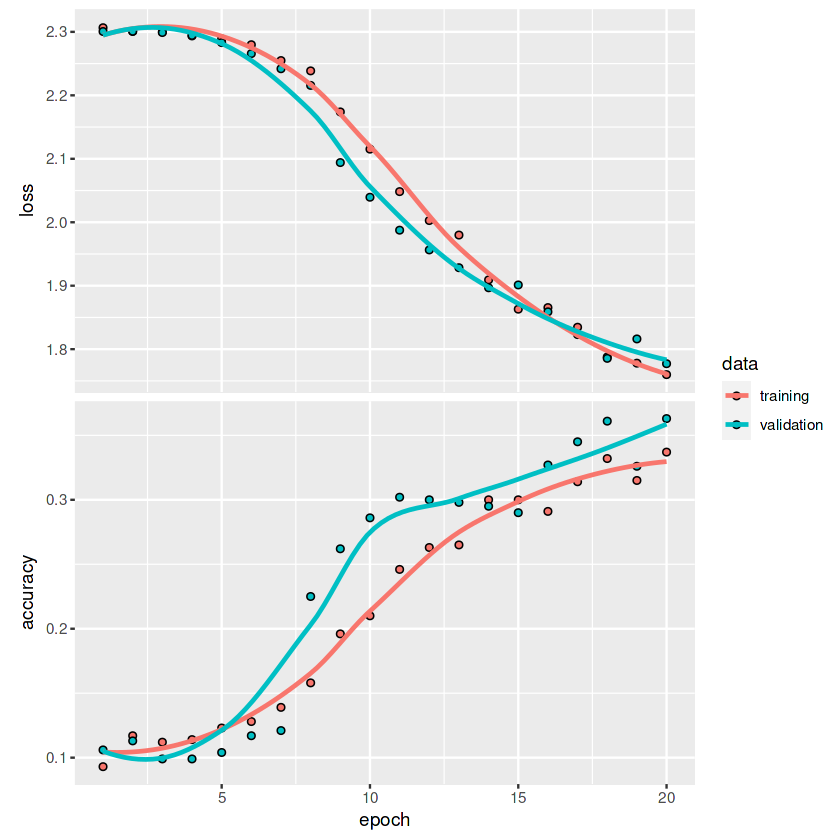

In [78]:
# train the model
history <- model_scratch %>% fit(
  X_train, Y_train, 
  epochs = 20, batch_size=batch_size,
  verbose=1, validation_data = list(X_val, Y_val))
plot(history)

In [80]:
results <- model_scratch %>% evaluate(X_test, Y_test, verbose=0)
results

loss accuracy 
1.727495 0.364100

In [82]:
sessionInfo()

R version 4.0.5 (2021-03-31)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.4 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas-pthread/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/openblas-pthread/liblapack.so.3

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] randomForest_4.6-14 forcats_0.5.2       stringr_1.4.1      
 [4] dplyr_1.0.10        purrr_0.3.4         readr_2.1.2        
 [7] tidyr_1.2.1         tibble_3.1.8        ggplot2_3.3.6      
[10] tidyverse_1.3.2     tensorflow_2.9.0    keras_2.6.0   